# 0.0 IMPORTS

In [1]:
import pandas as pd
import seaborn as sns
import umap.umap_ as umap
import numpy as np
import re



import sweetviz
from matplotlib import pyplot as plt
from scipy.cluster import hierarchy as hc
from sklearn.decomposition import PCA
from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp
from sklearn import ensemble as en
from sklearn.neighbors import NearestNeighbors
from sklearn import mixture as mx
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

c:\Users\Victor\Desktop\repos\pa005_clustering\clustering\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Victor\Desktop\repos\pa005_clustering\clustering\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Victor\Desktop\repos\pa005_clustering

## 0.1. Auxiliar Functions

In [2]:
def jupyter_settings():
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 10]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None

    sns.set()


## 0.2. Load Data

In [3]:
data_raw = pd.read_csv('datasets/Ecommerce.csv', encoding = 'unicode_escape')

data_raw = data_raw.drop(columns = ['Unnamed: 8'])

# 1.0. Data Description

In [4]:
df1 = data_raw.copy()

## 1.1. Rename Columns

In [5]:
df1.columns = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

## 1.2. Data Dimensions

In [6]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of cols: {df1.shape[1]}')

Number of rows: 541909
Number of cols: 8


## 1.3. Data Types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [8]:
df1.isnull().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [9]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [10]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [11]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change Types

In [12]:
# invoice data
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype('int64')

## 1.7. Descriptive Statistics

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [14]:
min_      = pd.DataFrame(num_attributes.apply(np.min)).T
max_      = pd.DataFrame(num_attributes.apply(np.max)).T
mean_     = pd.DataFrame(num_attributes.apply(np.mean)).T
median_   = pd.DataFrame(num_attributes.apply(np.median)).T
std_      = pd.DataFrame(num_attributes.apply(np.std)).T
range_    = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skew_     = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis_ = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
data_statistical = pd.concat([min_, max_, range_, mean_, median_, std_, skew_, kurtosis_]).T.reset_index()
data_statistical.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [15]:
data_statistical

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### 1.7.1.1 Numerical Attributes - Investigating

1. Negative Quantity (Devolution?)
2. Unit Price == 0 (Sales Promotion?)

### 1.7.2 Categorical Attributes

In [16]:
# INVOICE NUMBER

#cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'invoice_no'].drop_duplicates()
len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'invoice_no'].drop_duplicates())

3839

In [17]:
# STOCK CODE

#at_leat_one_string = len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'])
#at_leat_one_string

#cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()
df1.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
45,536370,POST,POSTAGE,3,2016-11-29,18.00,France,12583
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
386,536403,POST,POSTAGE,1,2016-11-29,15.00,Netherlands,12791
1123,536527,POST,POSTAGE,1,2016-11-29,18.00,Germany,12662
1814,536544,DOT,DOTCOM POSTAGE,1,2016-11-29,569.77,United Kingdom,19001


# 2.0. Data Filtering

In [18]:
df2 = df1.copy()

In [19]:
# Numerical Attributes #
# Unit price > 0.0
df2 = df2.loc[df2['unit_price'] > 0.010, :]

# stock code != [POST, D, M, DOT, CRUK]
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'DOT', 'CRUK', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B'])]

# description
df2 = df2.drop(columns='description', axis=1)

# map
df2 = df2[~df2['country'].isin( [ 'European Community', 'Unspecified'] )]

# bad users
df2 = df2[~df2['customer_id'].isin([16466])]

## quantity - Negative numbers means product returns
df_returns = df2.loc[df2['quantity'] < 0, :]
df_purchase = df2.loc[df2['quantity'] > 0, :]

In [20]:
#df2.loc[df2['quantity'] < 0, :].sort_values(['customer_id', 'description']).head()
#df2.loc[df2['invoice_no'].apply(lambda x: bool(re.search('.540152', x))), :].head()
#df2.loc[df2['customer_id'] == 12395, :].sort_values('description')

# 3.0. Feature Engineering

In [21]:
df3 = df2.copy()

## 3.1. Feature Creation

In [22]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis = 1).drop_duplicates(ignore_index=True)

### 3.1.1 Gross Revenue

In [23]:
# Gross Revenue (Faturamento)
df_purchase.loc[:, 'gross_revenue'] = df_purchase.loc[:, 'quantity'] * df_purchase.loc[:, 'unit_price']

# Monetary
df_monetary = df_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

c:\Users\Victor\Desktop\repos\pa005_clustering\clustering\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\Victor\Desktop\repos\pa005_clustering\clustering\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### 3.1.2 Recency - Day from last purchase

In [24]:
# Recency - Last day purchase
df_recency = df_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')


### 3.1.3 Quantity of purchased

In [25]:
# Frequency
df_freq = (df_purchase[['customer_id', 'invoice_no']].drop_duplicates()
                                                    .groupby('customer_id')
                                                    .count()
                                                    .reset_index()
                                                    .rename(columns={'invoice_no':'qtde_invoices'}))


df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

### 3.1.4 Quantity of items purchased

In [26]:
# Frequency
df_freq = (df_purchase[['customer_id', 'quantity']].groupby('customer_id')
                                                  .sum()
                                                  .reset_index()
                                                  .rename(columns={'quantity':'qtd_items'}))

df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

### 3.1.5 Quantity of stock purchased

In [27]:
# Frequency
df_freq = (df_purchase[['customer_id', 'stock_code']].groupby('customer_id')
                                                  .count()
                                                  .reset_index()
                                                  .rename(columns={'stock_code':'qtd_products'}))

df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

### 3.1.6 Average Ticket Value

In [28]:
# Avg Ticket
avg_ticket = df_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue' : 'avg_ticket'})
df_ref = pd.merge(df_ref, avg_ticket, on='customer_id', how='left')

### 3.1.7 Average Recency Days

In [29]:
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[True, True])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoice date

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis = 1).dropna()

# average recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left')

### 3.1.8 Frequency Purchase

In [30]:
df_aux = (df2[['invoice_no', 'customer_id', 'invoice_date']].drop_duplicates()
                                                            .groupby('customer_id')
                                                            .agg(max_ = ('invoice_date', 'max'),
                                                                 min_ = ('invoice_date', 'min'),
                                                                 days = ('invoice_date', lambda x: (( x.max() - x.min()).days) +1),
                                                                 buy_ = ('invoice_date', 'count'))).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days']].apply(lambda x: x['buy_'] / x['days'] if x['days'] != 0 else 0, axis = 1)

df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

### 3.1.9 Number of Returns

In [31]:
df2_returns = df_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtde_returns'})
df2_returns['qtde_returns'] = df2_returns['qtde_returns'] * -1
df_ref = pd.merge(df_ref, df2_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

### 3.1.10 Basket Size - Quantidade de items por cesta

In [32]:
df_aux = (df_purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                         .agg(n_purchase=('invoice_no', 'nunique'),
                                                                              n_products=('quantity', 'sum')).reset_index())

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')

### 3.1.11 Unique Basket Size

In [33]:
df_aux = (df_purchase.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                         .agg(n_purchase=('invoice_no', 'nunique'),
                                                                              n_products=('stock_code', 'count')).reset_index())

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')

# 4.0. EDA

In [34]:
df4 = df_ref.dropna().copy()

In [35]:
df4

,customer_id,gross_revenue,recency_days,qtde_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,0.486111,40.0,50.970588,8.735294
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,0.048780,35.0,154.444444,19.000000
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,0.045699,50.0,335.200000,15.466667
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,5.600000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.136364,22.0,26.666667,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
5658,12479,473.20,11.0,1.0,382.0,30.0,15.773333,4.000000,0.333333,34.0,382.000000,30.000000
5679,14126,706.13,7.0,3.0,508.0,15.0,47.075333,3.000000,1.000000,50.0,169.333333,5.000000
5685,13521,1092.39,1.0,3.0,733.0,435.0,2.511241,4.500000,0.300000,0.0,244.333333,145.000000
5695,15060,301.84,8.0,4.0,262.0,120.0,2.515333,1.000000,2.000000,0.0,65.500000,30.000000


## 4.1. Univariate Analysis

**Notes**

1. Clusters Coesos - Separados
2. Métricas
    - Min, Máximo, Range(Dispersão)
    - Média e Mediana
    - Desvio Padrão e Variância
    - Coeficiente de Variação (CV)
    - Distribuição

In [36]:
#my_report = sweetviz.analyze(df4)
#my_report.show_html('Report.html')

### 4.1.1 Gross Revenue

In [37]:
df4[df4['customer_id'] == 14646]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.206215,288.0,2733.944444,28.611111


### 4.1.2 Qtde Items

In [38]:
df4[df4['qtd_products'] == 7838]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
68,17841,40967.72,1.0,124.0,23053.0,7838.0,5.226808,3.321429,0.453083,203.0,185.91129,63.209677


### 4.1.3 Avg items

In [39]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
3337,16446,168472.5,0.0,2.0,80997.0,3.0,56157.5,205.0,0.014563,80995.0,40498.5,1.5


## 4.2. Bivariate Analysis

In [40]:
#plt.figure(figsize=(25, 12))
#sns.pairplot(df4[['gross_revenue', 'avg_ticket', 'frequency', 'avg_recency_days', 'recency_days', 'qtde_invoices', 'qtde_returns', 'avg_basket_size']]);

## 4.3. Estudo do Espaço

In [41]:
df43 = df4.drop(columns=['customer_id']).copy()

In [42]:
mms = pp.MinMaxScaler()

In [43]:
df43['gross_revenue']          = mms.fit_transform(df43[['gross_revenue']])
df43['recency_days']           = mms.fit_transform(df43[['recency_days']])
df43['qtde_invoices']          = mms.fit_transform(df43[['qtde_invoices']])
df43['qtd_products']           = mms.fit_transform(df43[['qtd_products']])
df43['avg_ticket']             = mms.fit_transform(df43[['avg_ticket']])
df43['avg_recency_days']       = mms.fit_transform(df43[['avg_recency_days']])
df43['frequency']              = mms.fit_transform(df43[['frequency']])
df43['qtde_returns']           = mms.fit_transform(df43[['qtde_returns']])
df43['avg_basket_size']        = mms.fit_transform(df43[['avg_basket_size']])
df43['avg_unique_basket_size'] = mms.fit_transform(df43[['avg_unique_basket_size']])

In [44]:
X = df43.copy()

### 4.3.1 PCA

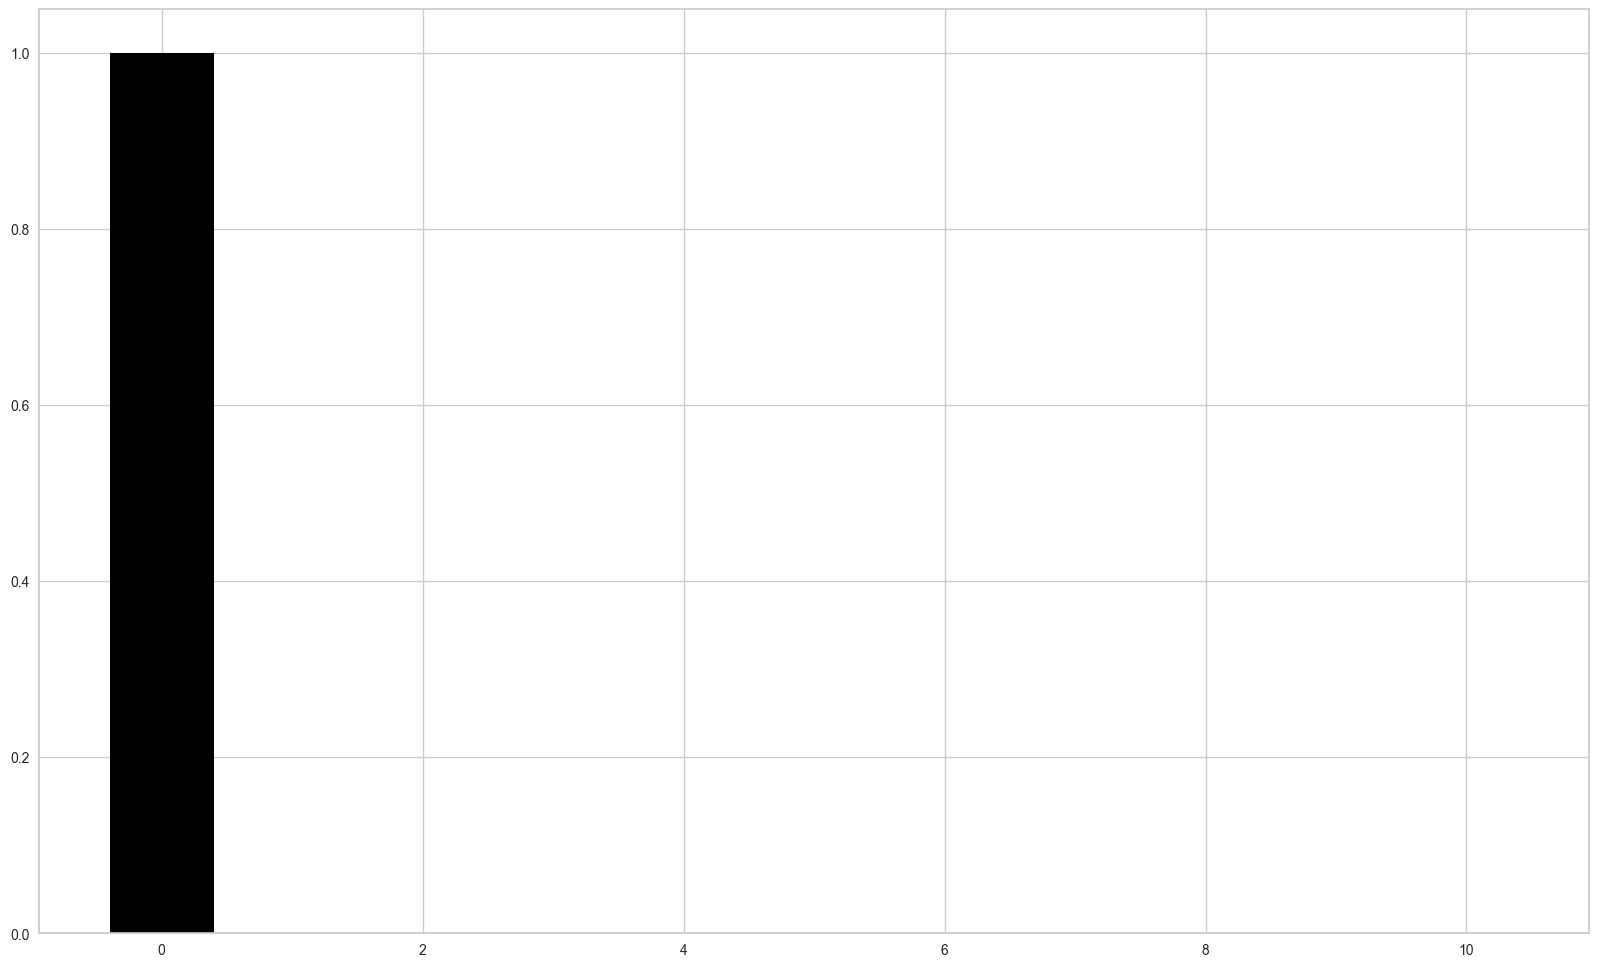

In [45]:
pca = PCA(n_components=X.shape[1])
principal_component = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)
plt.figure(figsize=(20,12))
plt.bar(features, pca.explained_variance_ratio_, color='black')

# pca component
df_pca = pd.DataFrame(principal_component)

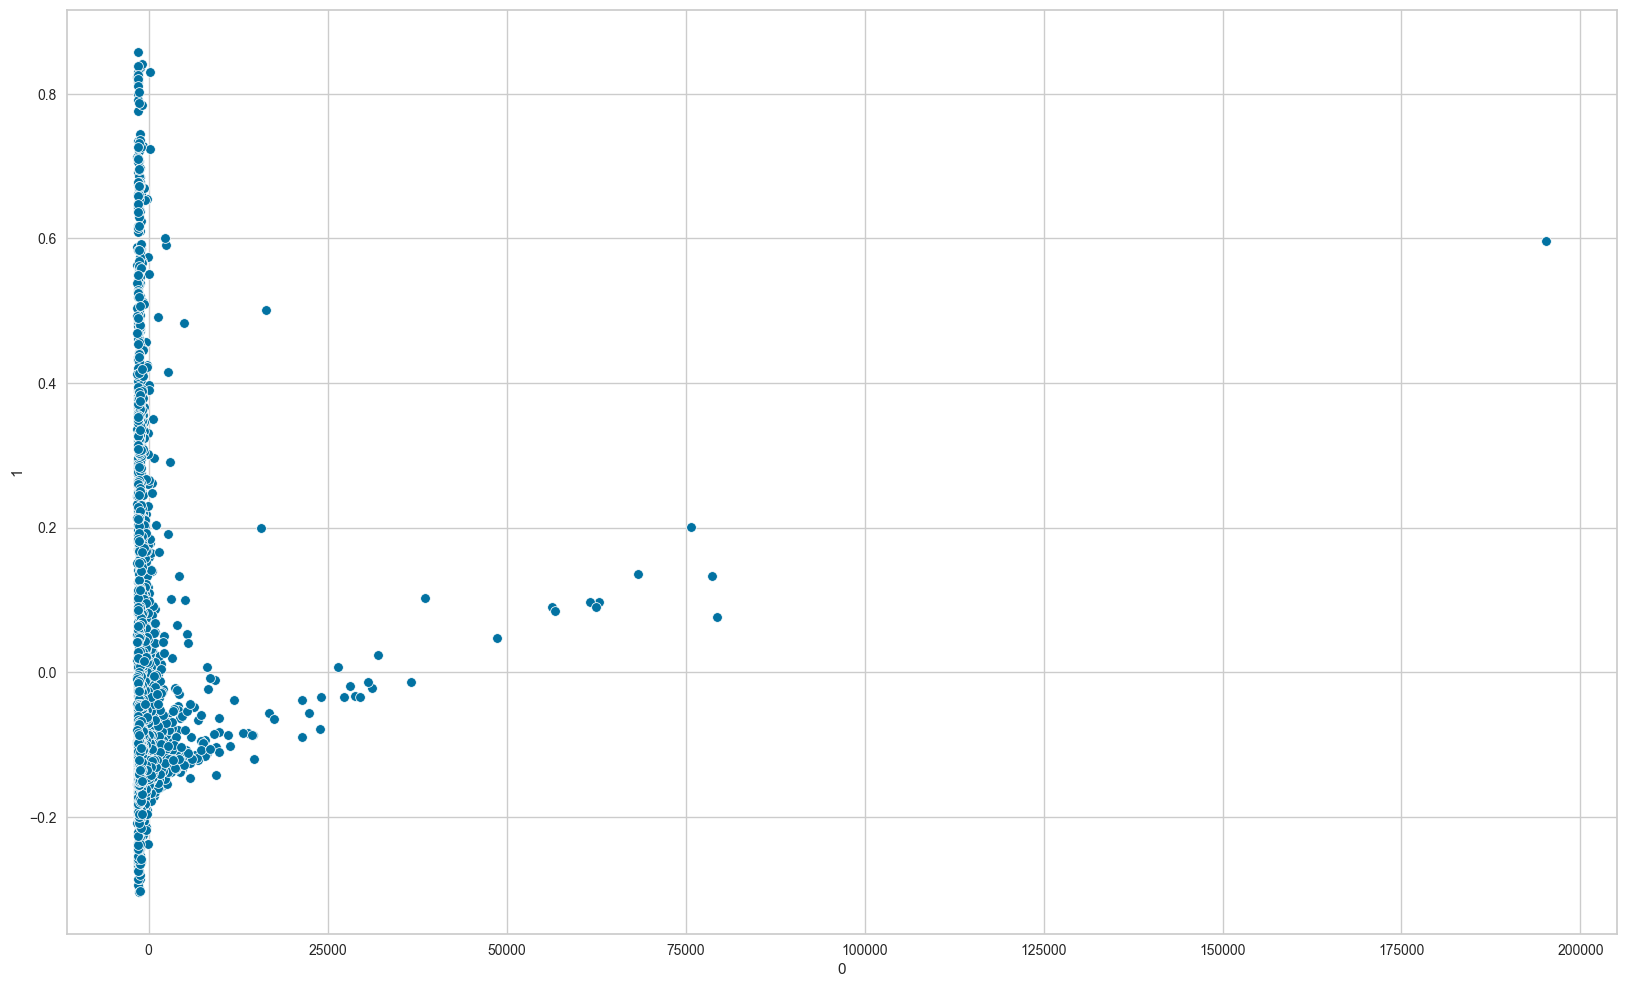

In [46]:
plt.figure(figsize=(20, 12))
sns.scatterplot(x=0, y=1, data=df_pca);

### 4.3.2 UMAP

c:\Users\Victor\Desktop\repos\pa005_clustering\clustering\lib\site-packages\numba\np\ufunc\parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


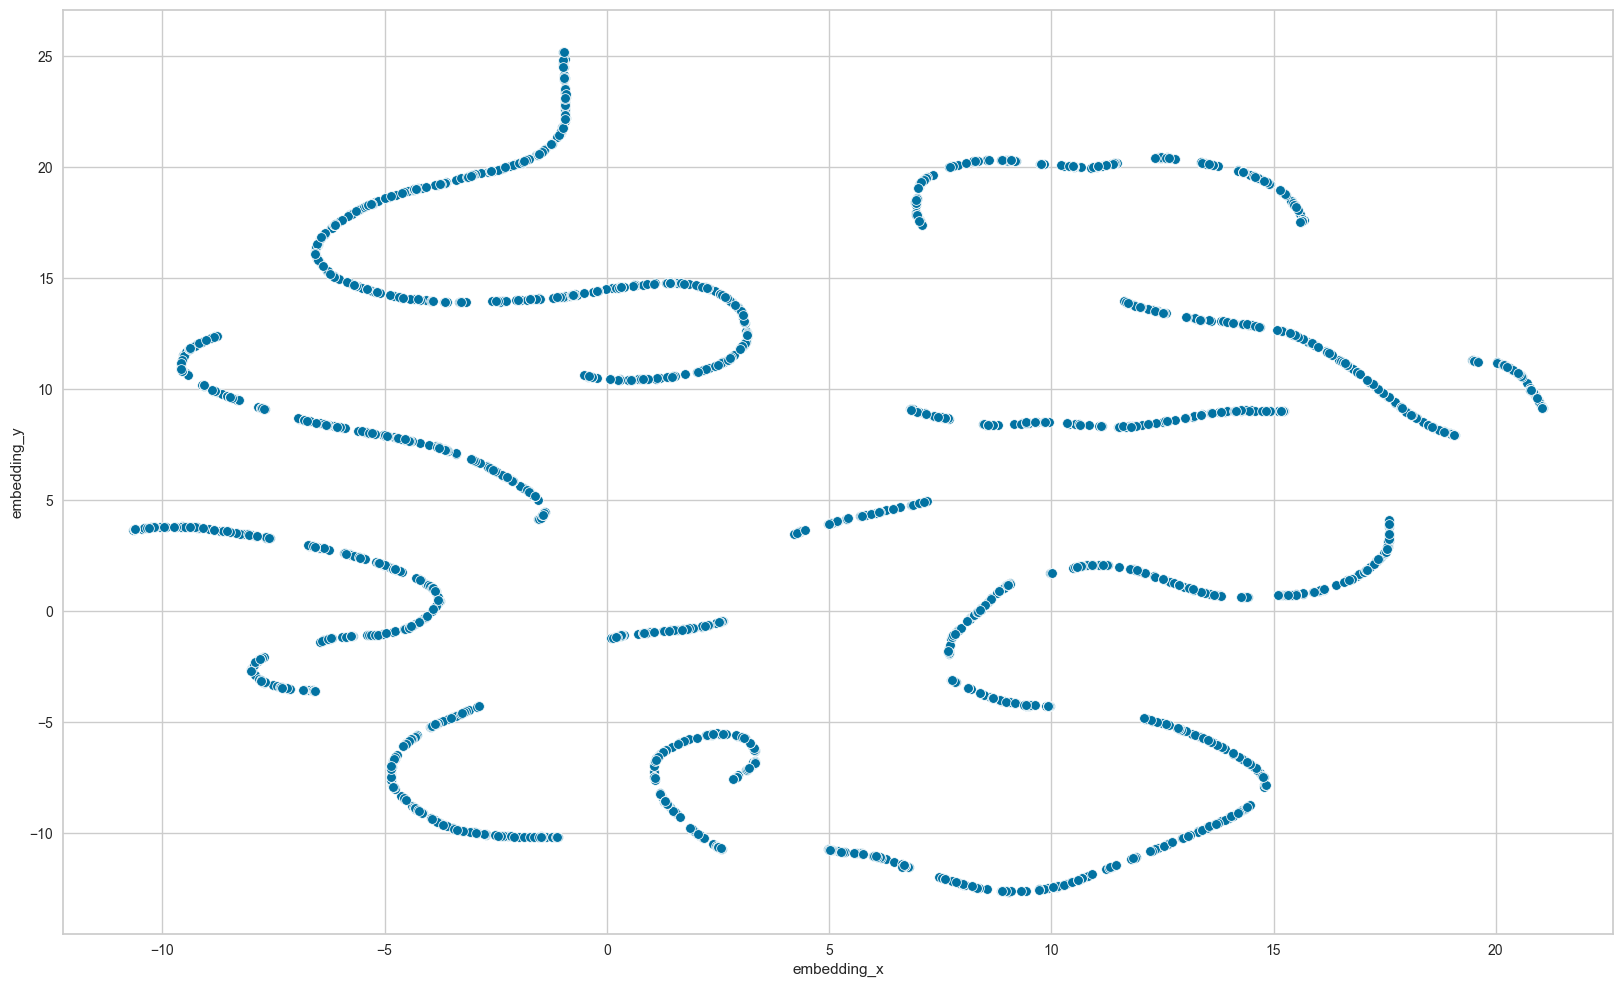

In [47]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot
plt.figure(figsize=(20,12))
sns.scatterplot(x='embedding_x', y='embedding_y', data = df_pca);

### 4.3.3 t-SNE

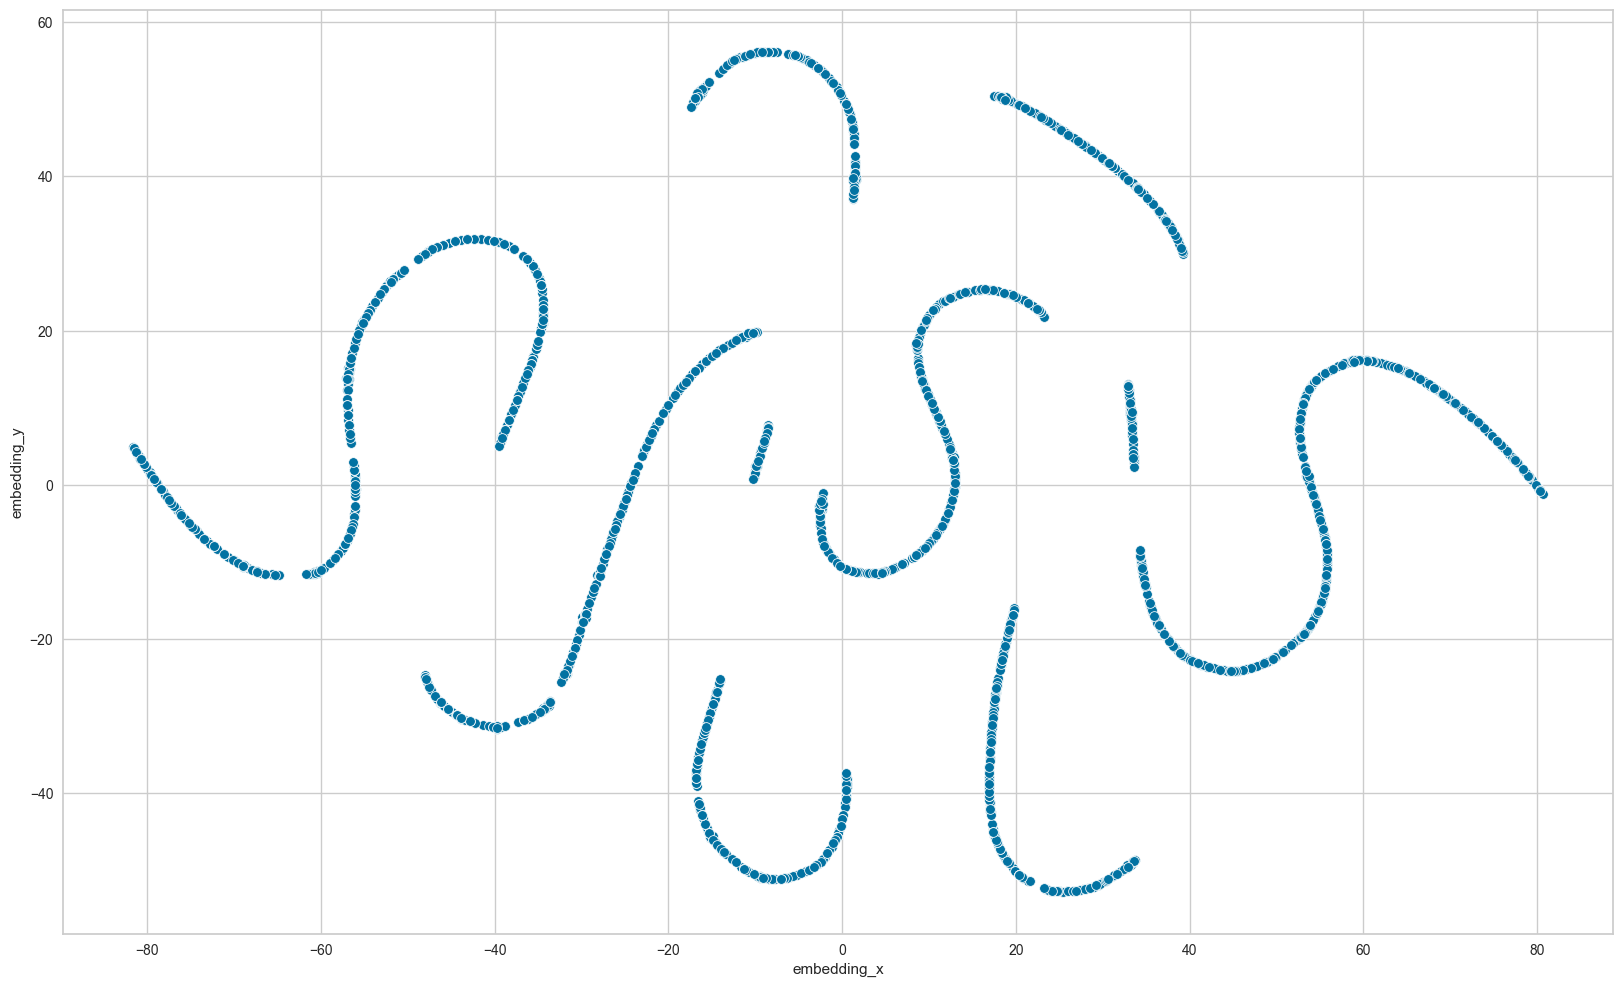

In [48]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot
plt.figure(figsize=(20,12))
sns.scatterplot(x='embedding_x', y='embedding_y', data = df_pca);

### 4.3.4 Tree Based Embedding

In [49]:
X = df4.drop(columns=['customer_id', 'gross_revenue'], axis = 1)
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

# Leaf
df_leaf = pd.DataFrame(rf_model.apply(X))


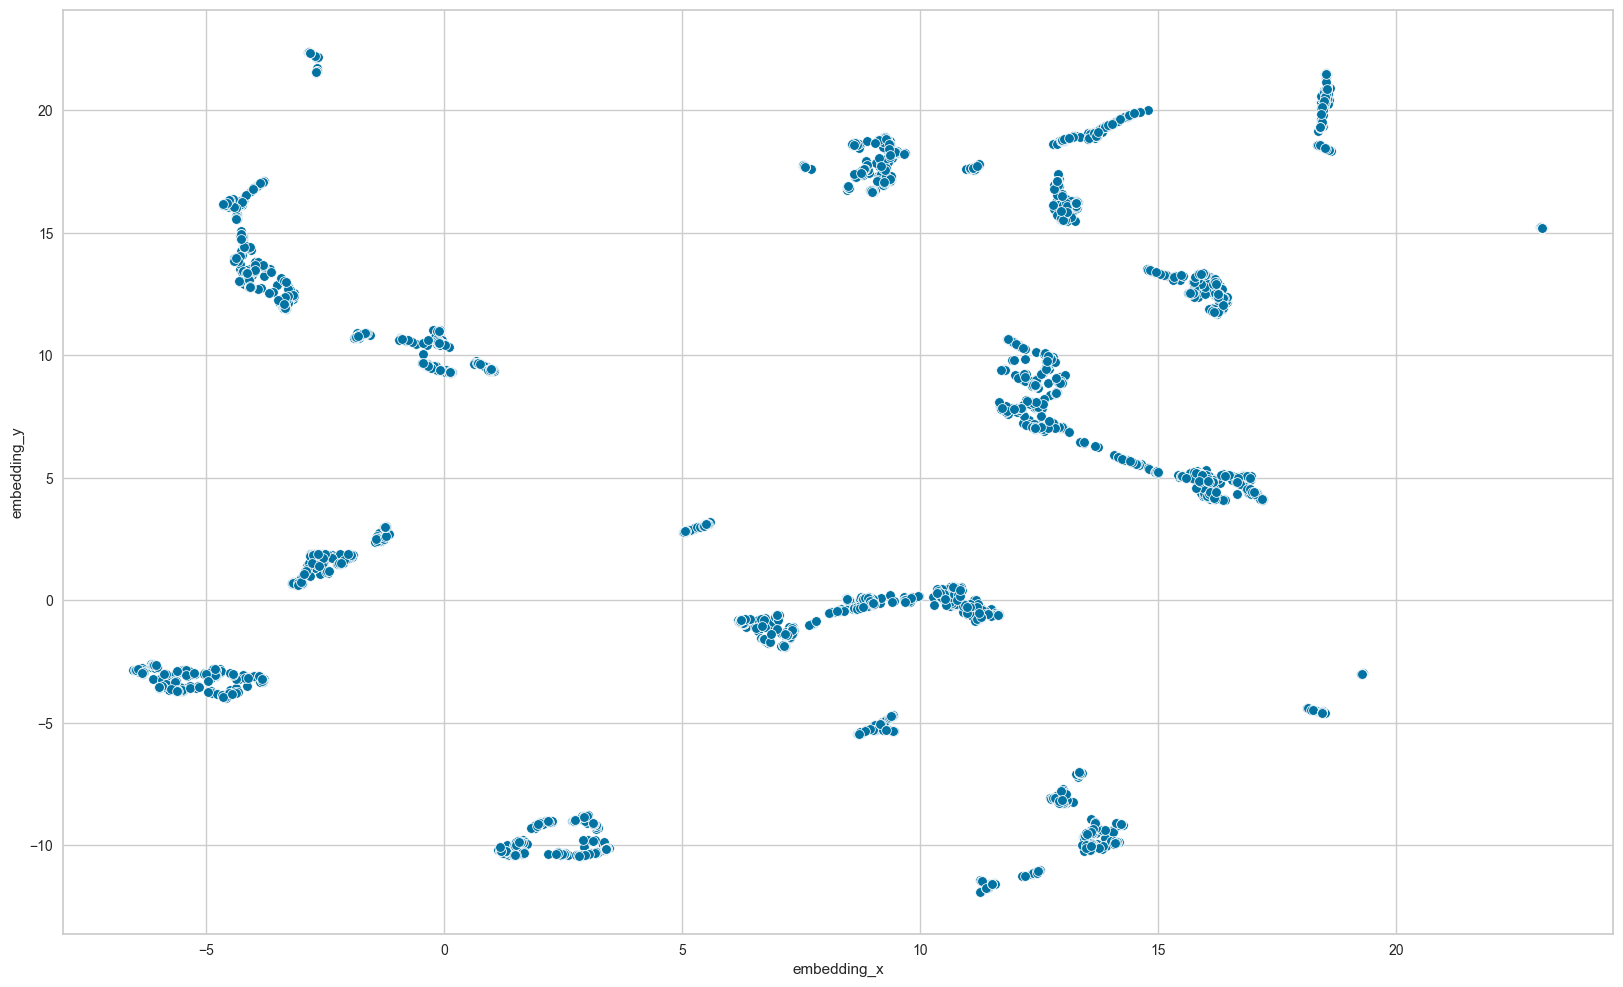

In [50]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot
plt.figure(figsize=(20,12))
sns.scatterplot(x='embedding_x', y='embedding_y', data = df_pca);

# 5.0. Data Preparation

In [51]:
df5 = df4.copy()

In [52]:
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['qtde_invoices'] = ss.fit_transform(df5[['qtde_invoices']])
df5['qtd_products'] = ss.fit_transform(df5[['qtd_products']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])
df5['avg_recency_days'] = ss.fit_transform(df5[['avg_recency_days']])
df5['frequency'] = ss.fit_transform(df5[['frequency']])
df5['qtde_returns'] = ss.fit_transform(df5[['qtde_returns']])
df5['avg_basket_size'] = ss.fit_transform(df5[['avg_basket_size']])
df5['avg_unique_basket_size'] = ss.fit_transform(df5[['avg_unique_basket_size']])
df5['qtd_items'] = ss.fit_transform(df5[['qtd_items']])

# 6.0. Feature Selection

In [53]:
df6 = df5.copy()

# 7.0. Hyperparameter Fine Tunning

In [54]:
X = df6.drop(columns=['customer_id'])

## 7.1. Within-Cluster Sum of Square (WSS)

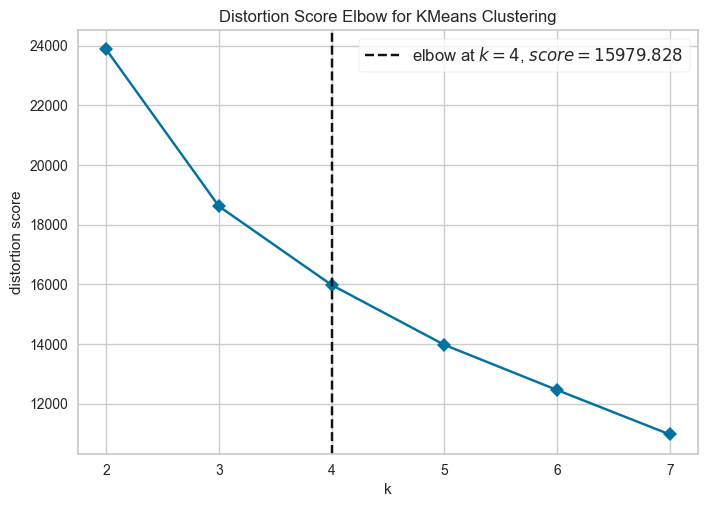

In [55]:
clusters = [2, 3, 4, 5, 6, 7]
kmeans = KElbowVisualizer( c.KMeans(n_init=10), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 7.2. Silhouette Score

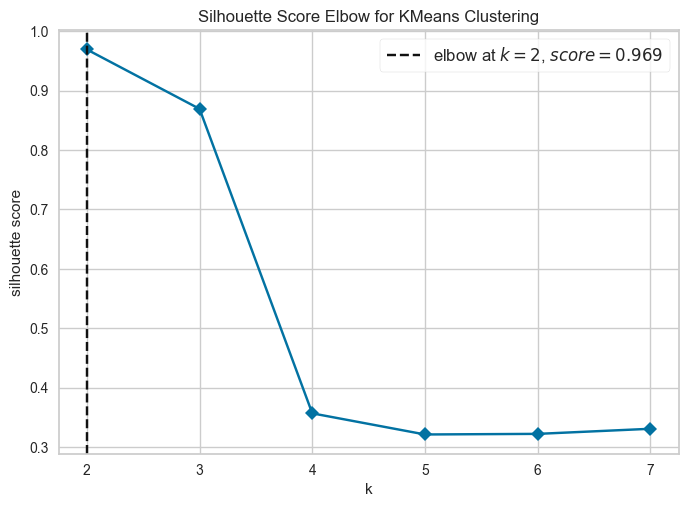

In [56]:
kmeans = KElbowVisualizer(c.KMeans(n_init=10), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show();

### 7.2.1 Silhouette Analysis

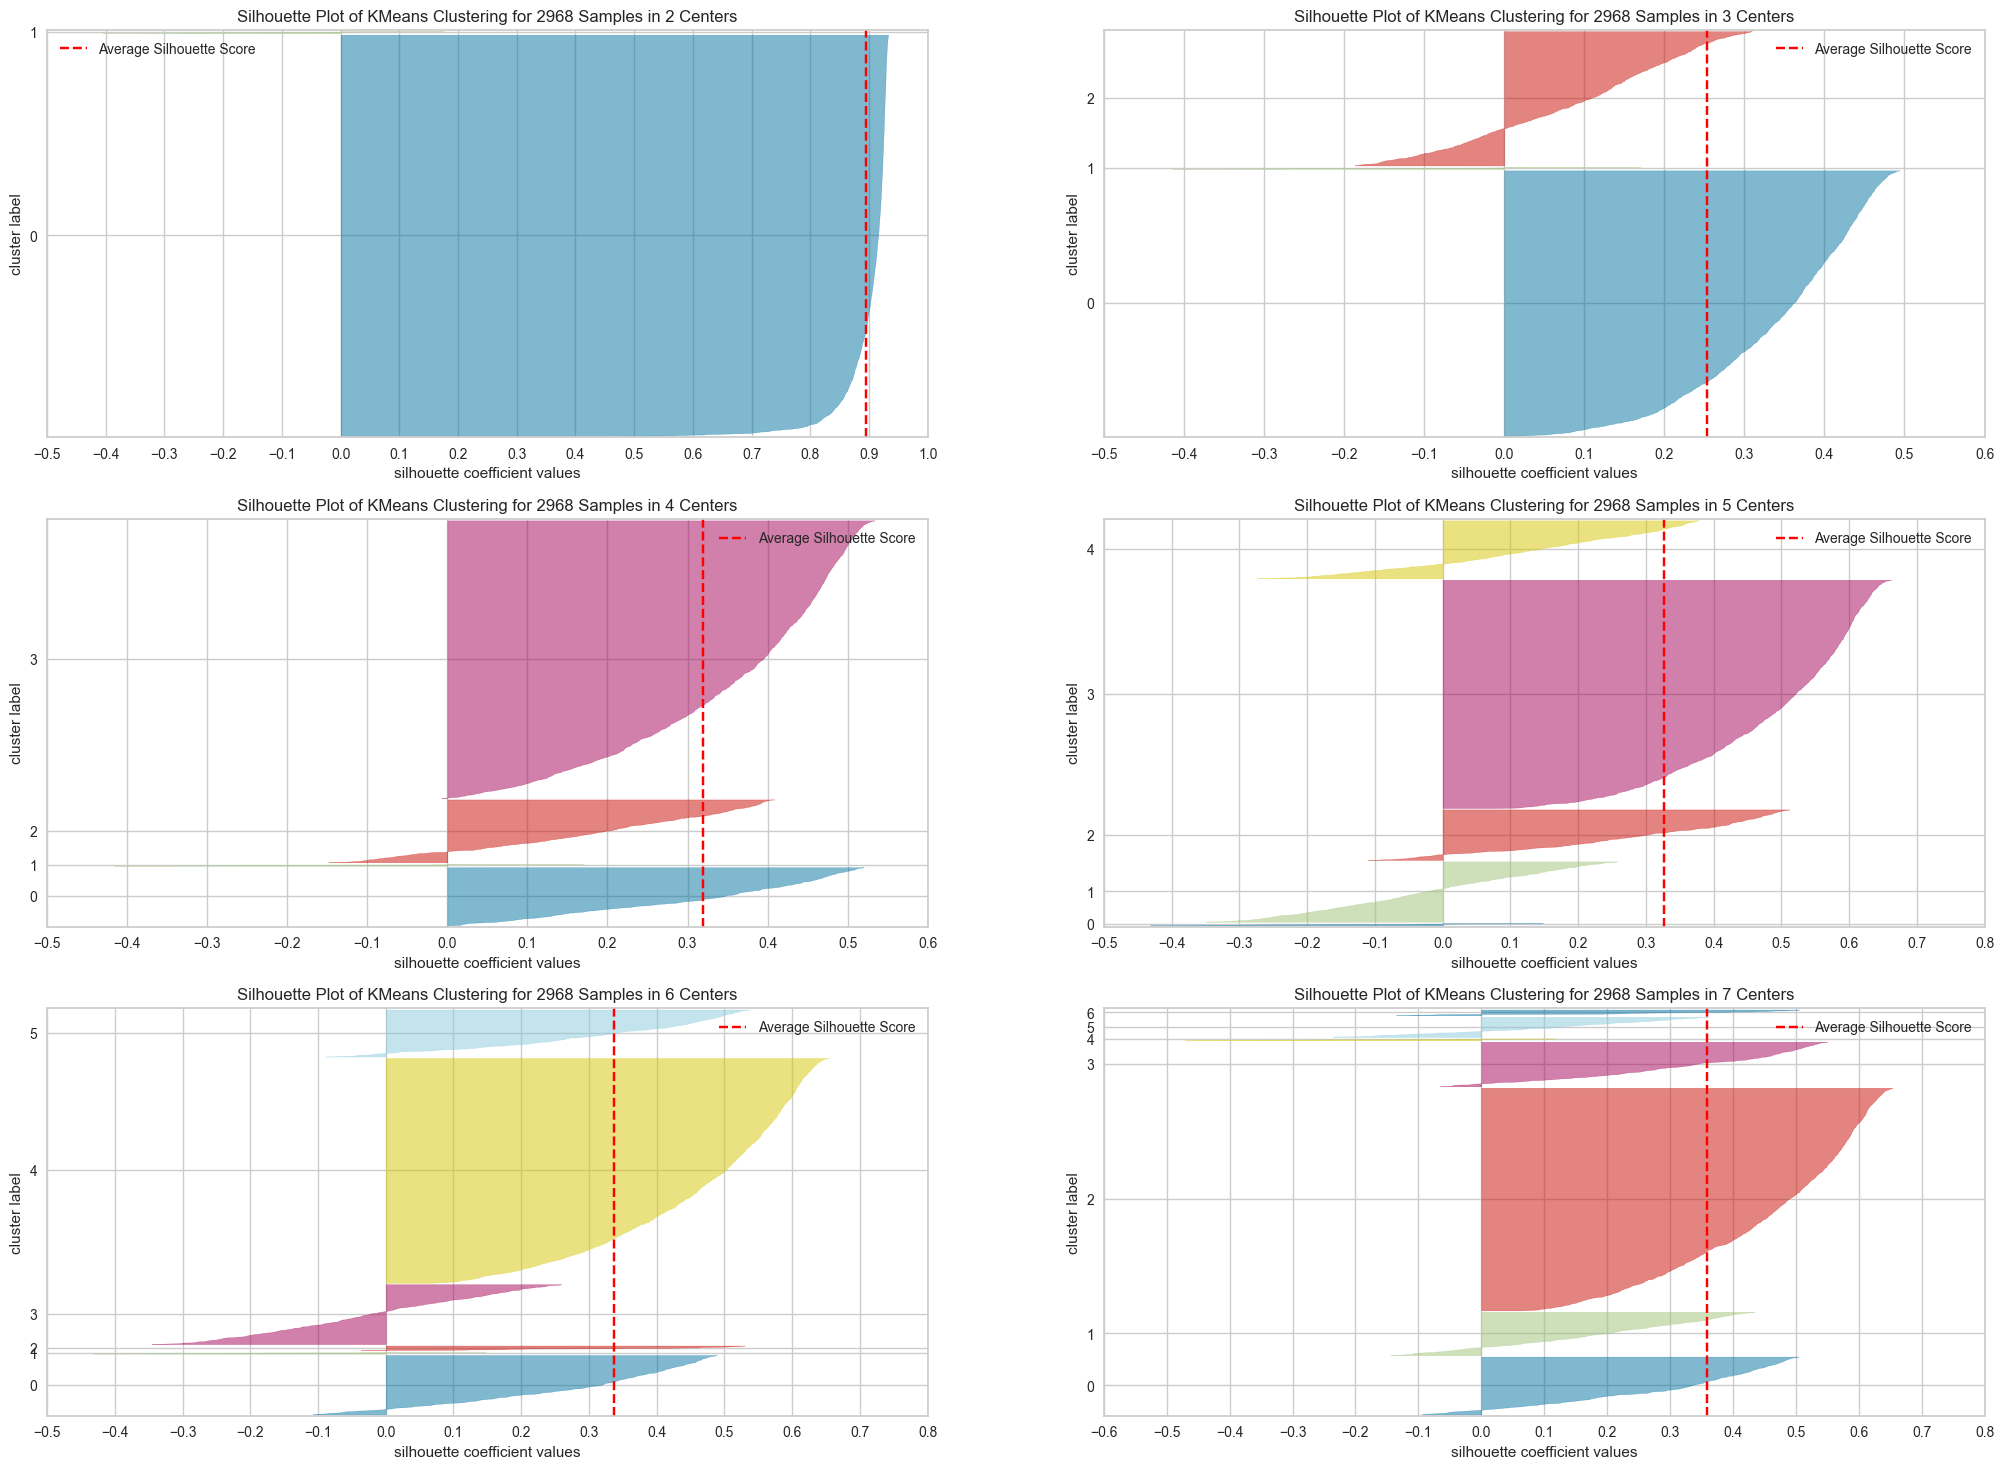

In [57]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize();

## 7.3. GMM

In [58]:
gmm_list = []
# model definition
for k in clusters:
    gmm_model = mx.GaussianMixture(n_components=k)

    # model training
    gmm_model.fit(X)
    
    # model predict
    labels = gmm_model.predict(X)

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

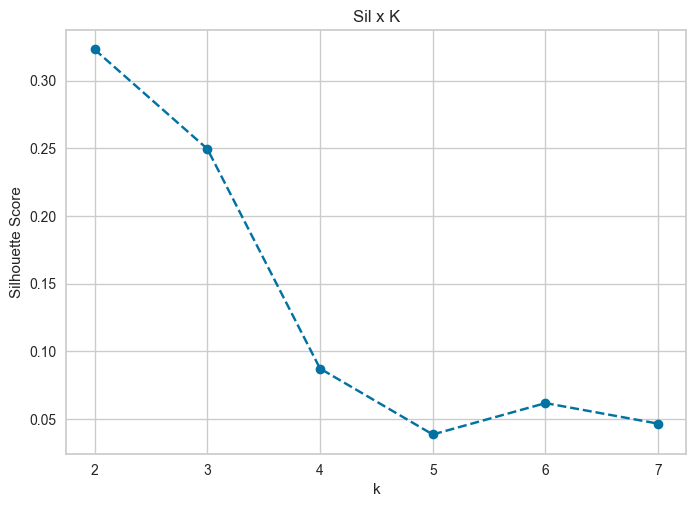

In [59]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Sil x K');

## 7.4. Hierarchical Clustering

In [60]:
hc_model = hc.linkage(X, 'ward')

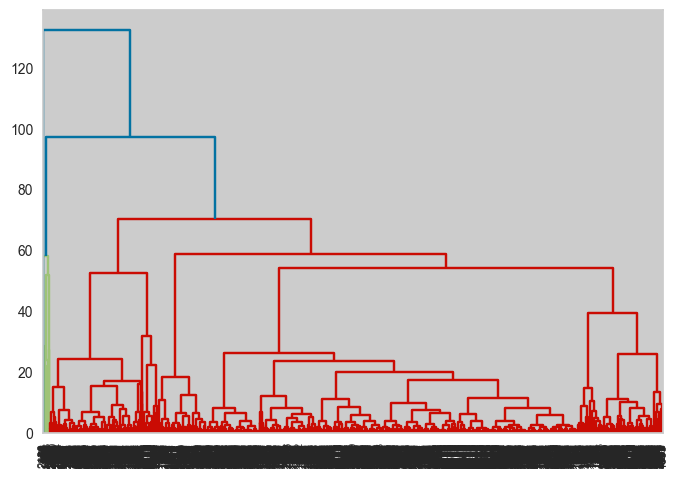

In [61]:
hc.dendrogram(hc_model,
              leaf_rotation=90,
              leaf_font_size=8)

plt.show();

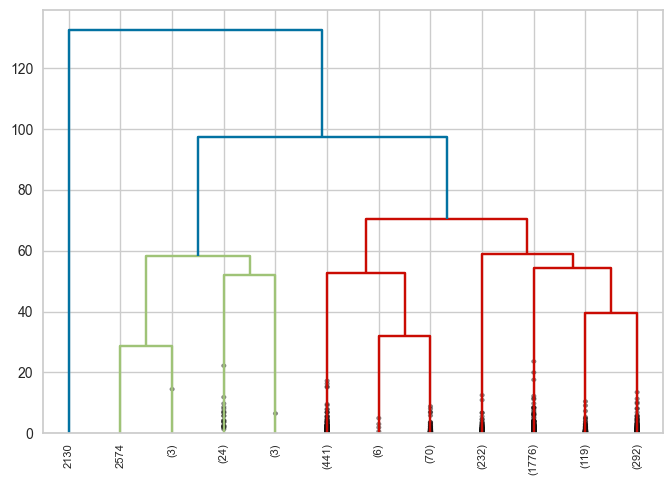

In [62]:
hc.dendrogram(hc_model,
              truncate_mode='lastp',
              p=12,
              leaf_rotation=90,
              leaf_font_size=8,
              show_contracted=True)

plt.show();

In [63]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # metrics
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

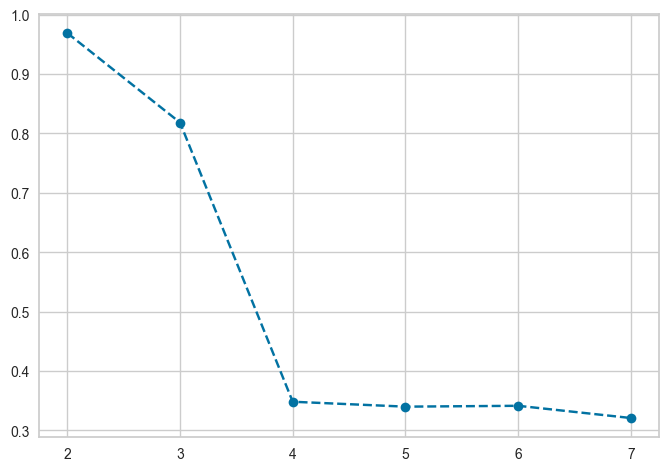

In [64]:
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b')

## 7.5. DBSCAN

In [65]:
eps=1.0
min_samples=20

# model definition
dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

# model training and predict
labels = dbscan_model.fit_predict(X)

sil = m.silhouette_score(X, labels, metric='euclidean')
print('Silhoette Score: {}'.format(sil))
print('Number of Clusters: {}'.format(len(np.unique(labels))))
print(np.unique(labels))

Silhoette Score: 0.6095501767567516
Number of Clusters: 2
[-1  0]


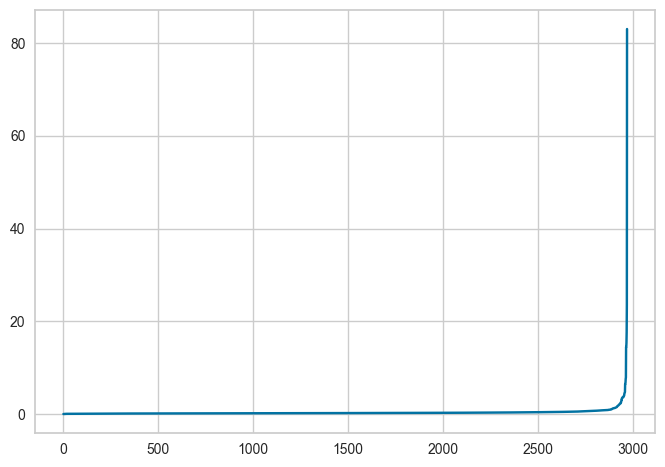

In [66]:
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, indices = neighbors.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.plot(distances);

In [67]:
dbscan_list = [0.609550, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## 7.6. Kmeans

In [68]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_init = 10, n_clusters=k)

    # model training
    kmeans_model.fit(X)

    # model predict
    labels = kmeans_model.predict(X)

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil);

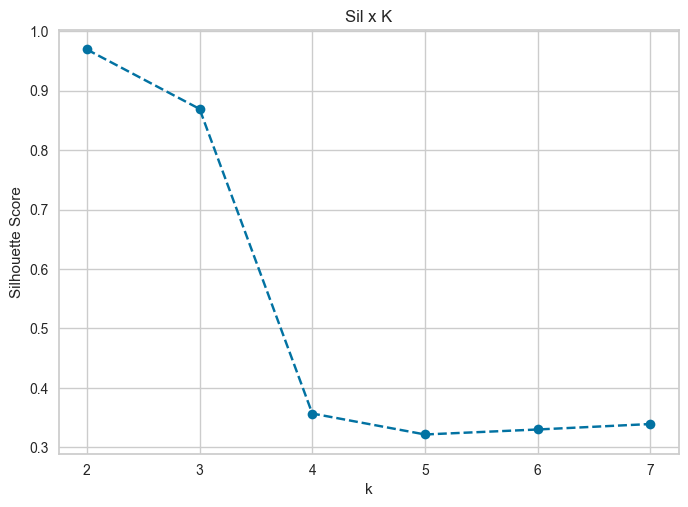

In [69]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Sil x K');

## 7.7. Results

In [70]:
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
     'GMM': gmm_list,
     'HC': hc_list,
     'DBScan': dbscan_list}
).T

df_results.columns = clusters

In [71]:
df_results.style.highlight_max(color='lightgreen', axis = 1)

,2,3,4,5,6,7
KMeans,0.969091,0.869146,0.356988,0.321742,0.330125,0.339317
GMM,0.323101,0.249688,0.087389,0.038687,0.061863,0.046676
HC,0.969091,0.818335,0.348102,0.339841,0.341278,0.320672
DBScan,0.609550,0.000000,0.000000,0.000000,0.000000,0.000000


# 8.0. Model Training

## 8.1 KMeans

In [239]:
# model difnition
k = 4
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.1.1 Cluster Validation

In [240]:
## WSS
print(f'WSS value: {kmeans.inertia_}')

## SS (Silhouette Score)
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value: 10489.750577409233
SS value: 0.5466207065096579


# 9.0. Cluster Analysis

## 9.1. Visualization Inspection

c:\Users\Victor\Desktop\repos\pa005_clustering\clustering\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


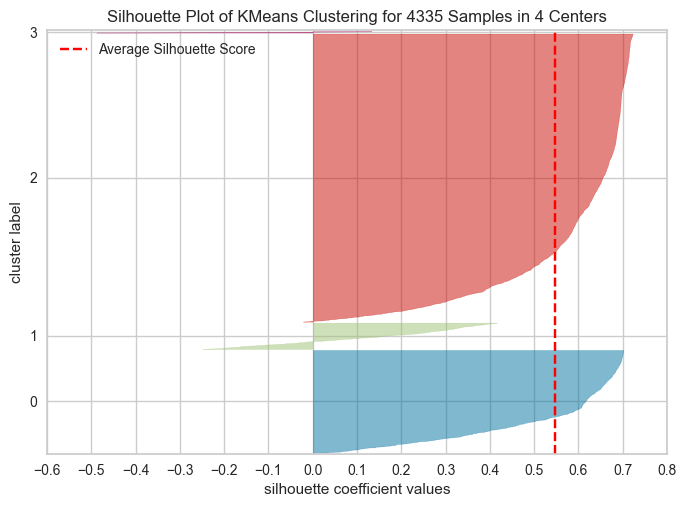

In [241]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize();

### 9.1.1 2d plot

In [242]:
df9 = df6.copy()
df9['cluster'] = labels
df9['cluster'] = df9['cluster'].astype('int64')
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns,cluster
0,17850.0,0.377555,2.792291,3.891594,-0.033914,0.114969,0
1,13047.0,0.135617,-0.361628,0.621543,-0.033402,3.160125,1
2,12583.0,0.524847,-0.900589,1.406356,-0.026593,0.622495,1
3,13748.0,-0.120412,0.027621,0.098335,-0.023213,-0.392557,2
4,15100.0,-0.128510,2.403041,-0.163269,0.152575,1.130021,0


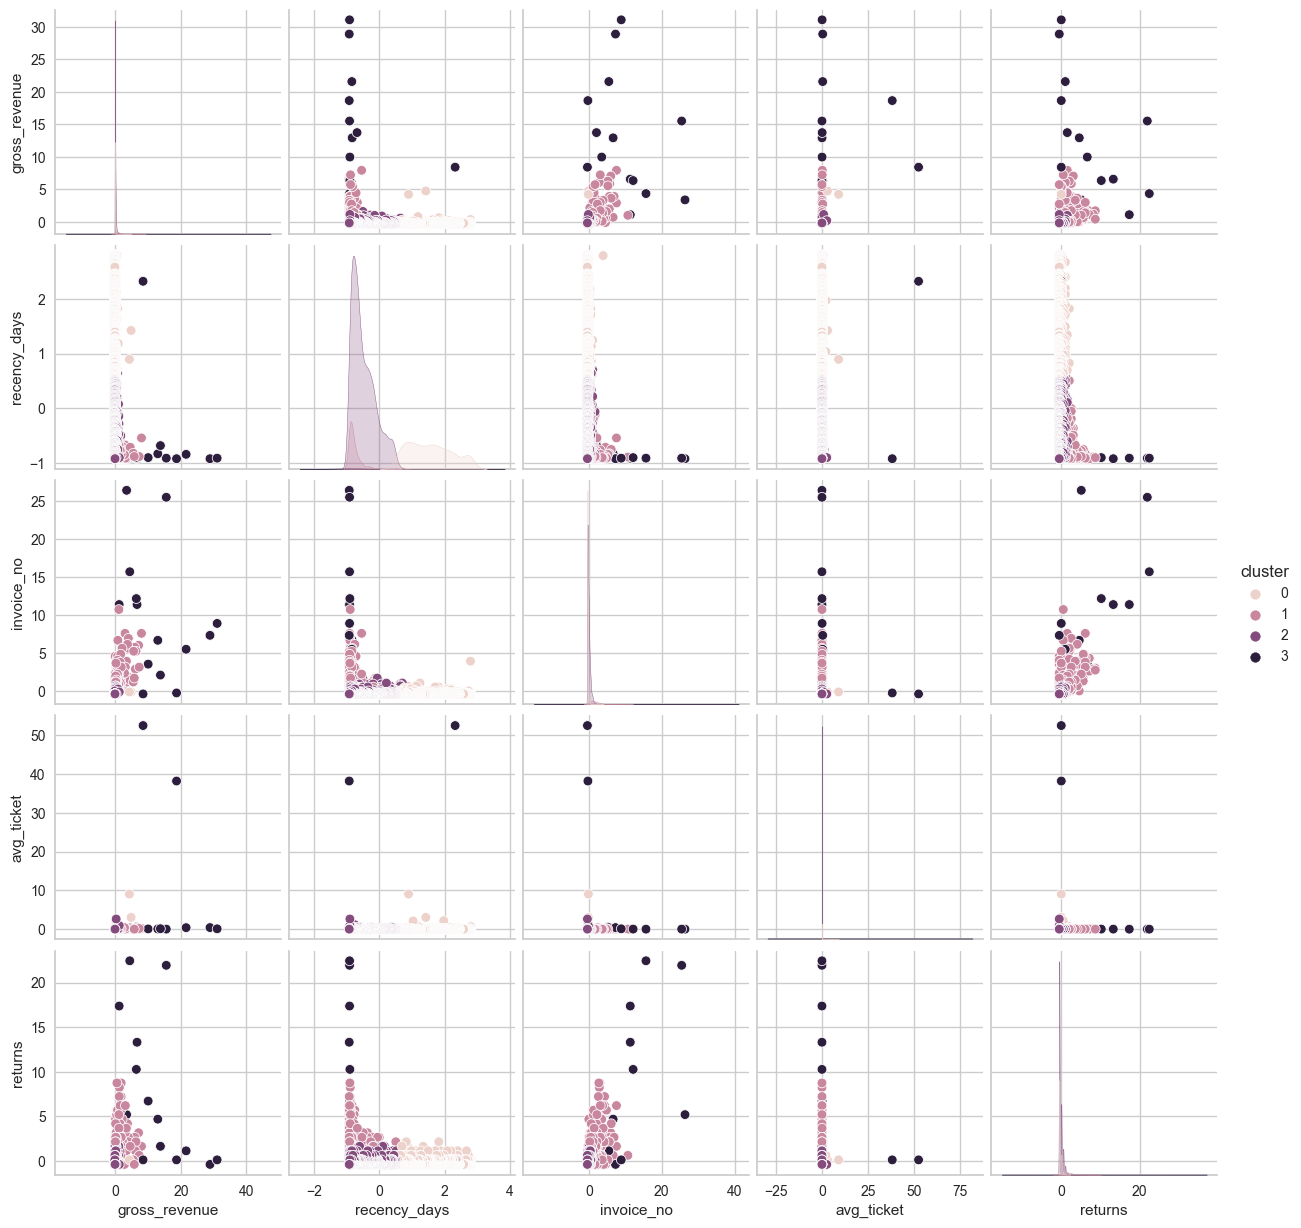

In [246]:
df_viz = df9.drop(columns='customer_id', axis=1)

sns.pairplot(df_viz, hue='cluster');

### 9.1.2 UMAP

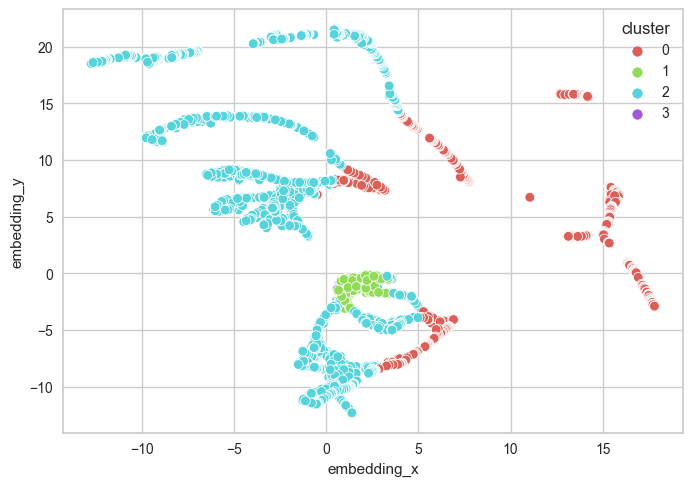

In [245]:
reducer = umap.UMAP(n_neighbors= 20,  random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot(x='embedding_x', y='embedding_y', data = df_viz, hue='cluster', palette=sns.color_palette('hls', n_colors = len(df_viz['cluster'].unique())));

## 9.2. Cluster Profile

In [43]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='left', on='cluster')

# Avg invoice_no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, how='inner', on='cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,38,0.869167,23181.925000,12.868421,43.078947,144.283757
1,1,3,0.068618,241136.560000,3.000000,64.666667,420.140475
2,2,15,0.343092,71423.516000,7.400000,67.866667,147.055408
3,3,3896,89.112534,817.913748,99.906057,3.322382,24.120000
4,4,420,9.606587,5804.281619,25.119048,15.230952,55.151451
